In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from tsfresh import extract_features
import pandas as pd
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [ ]:
with open('combined.pickle', 'rb') as f:
    all_data = pickle.load(f)

In [25]:
x = all_data[:,:-1]

y = all_data[:,-1]
'''
for i in range(11):
    y[i] = 1
for i in range(11,24):
    y[i] = 0
    #print(y[i])
''' 
x = x.astype(float)
y = y.astype(int)
print(y)
print(len(y))
print(len(x))

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
105
105


In [9]:
def inrange(this_range, n):
    if this_range == []:
        return 0

    if n > this_range[0] and n < this_range[1]:
        return 1
def adjust_interval(itrange, itmid):
            
    if inrange(itrange, 180): # range include 180,  170 ~ 190
        range_1 = [itrange[0], 180]
        range_2 = [-180, itrange[1]-360]
    elif itrange[0] >= 180 : # range over 180, 190 ~ 210 --> -170 ~ -150 
        range_1 = [itrange[0]-360, itrange[1]-360]
        range_2 = []    
    elif itrange[1] <= -180 : # range over -180, -210 ~ -190
        range_1 = [itrange[0] + 360, itrange[1] + 360]
        range_2 = []
    elif inrange(itrange, -180): # range include -180,  -190 ~ -170
        range_1 = [360 + itrange[0], 180]
        range_2 = [-180, itrange[1]]
    else:
        range_1 = itrange
        range_2 = []
    if itmid > 180:
        itmid = -180 + (itmid-180)
    elif itmid < -180:
        itmid = 180 - (-180 - itmid)
    return [range_1,range_2], itmid
        
        

In [10]:
affi = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']
linka = ['ward', 'complete', 'average', 'single']
cluster_model = AgglomerativeClustering(n_clusters=2,affinity=affi[0],linkage=linka[3])
linear_model = LinearRegression(fit_intercept=True)

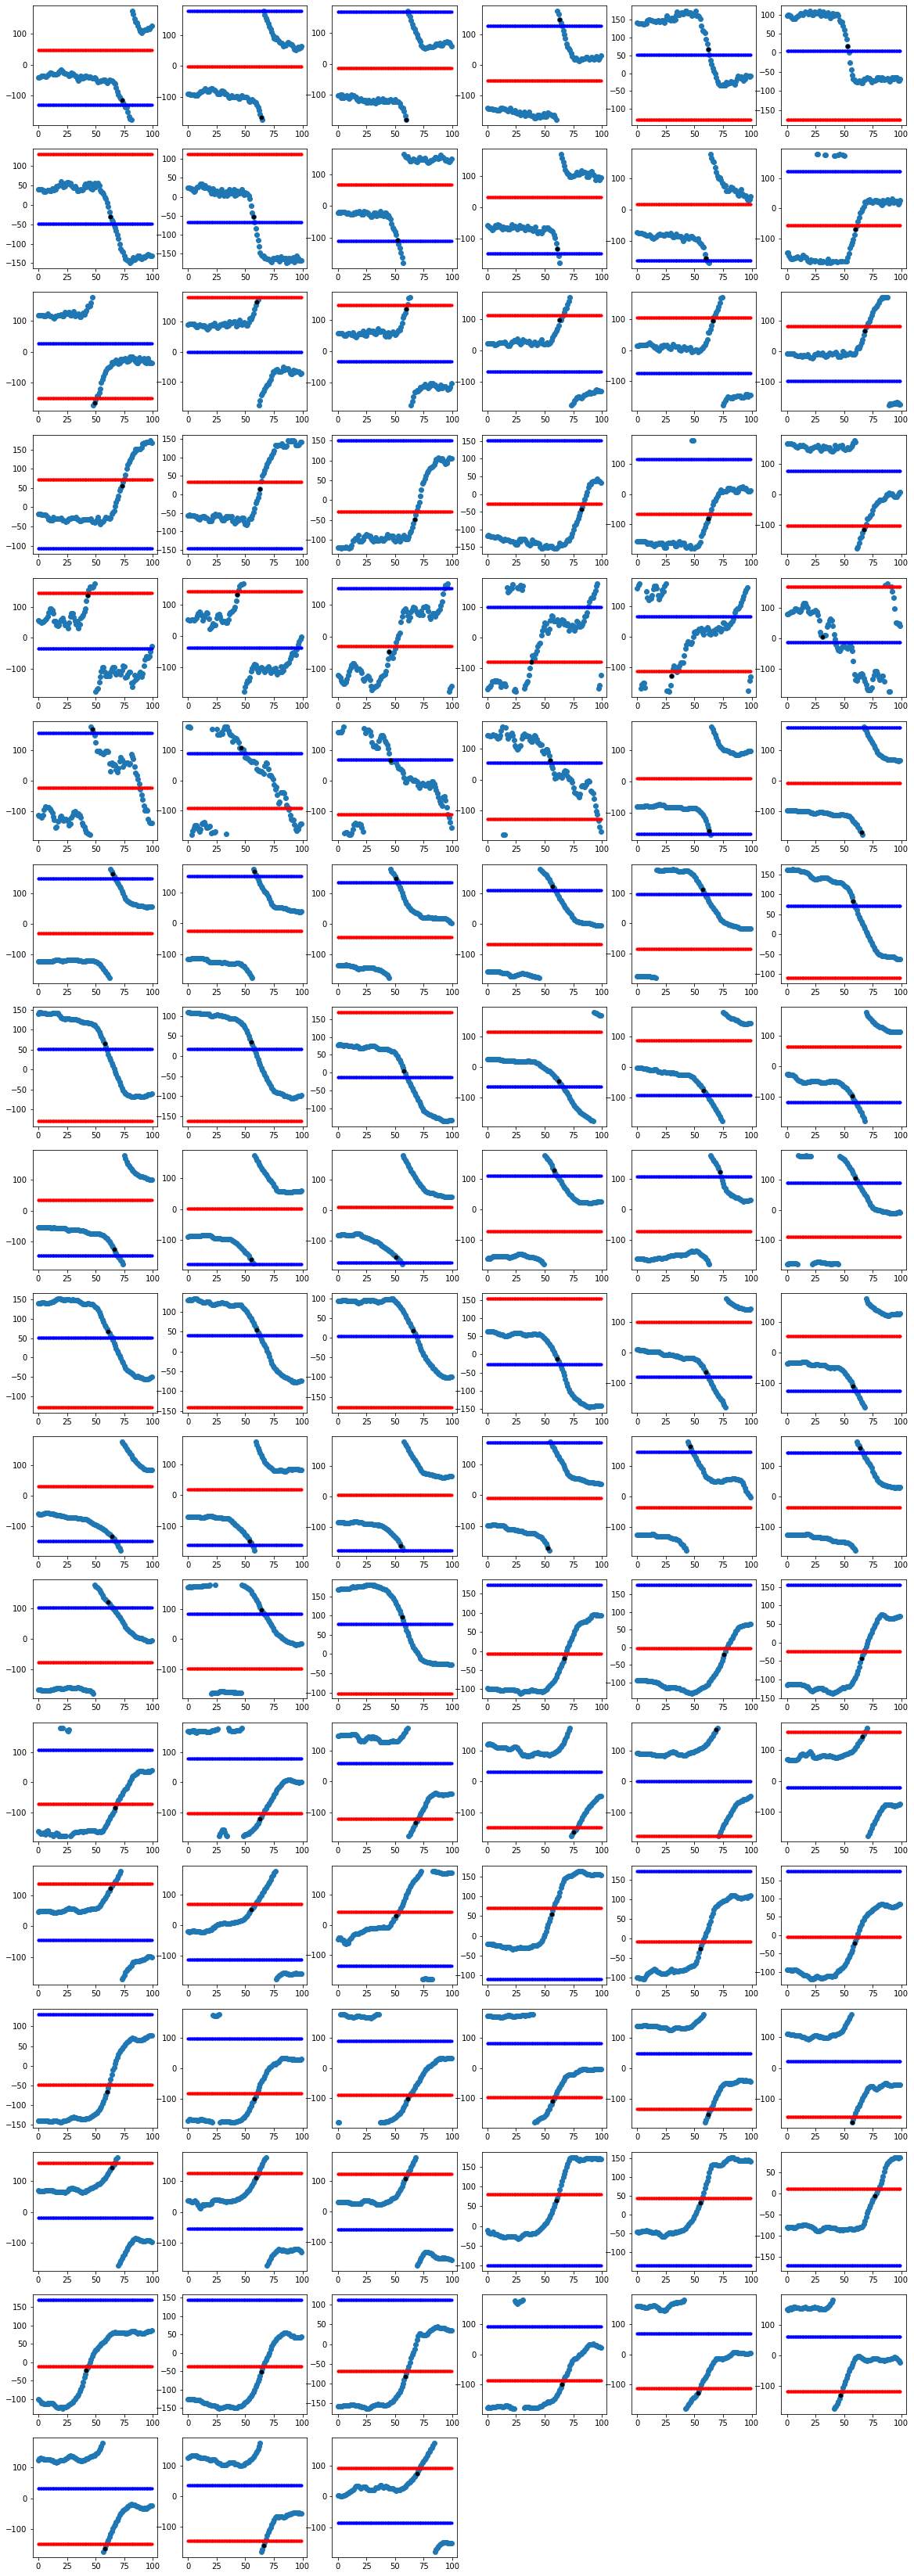

In [27]:
index = np.arange(len(x[0]))
graph_ = [0]*len(index)

plt.figure(figsize = (20,60))
plt.ylim(-180,180)
updown_cnt = 0 #up plus 1, down minus one
cnt_enough = 1
updown_ans = []
#print(len(x))
for ii,sample in enumerate(x):

    #plt.subplot(6,6,ii+1)
    plt.subplot(18,6,ii+1)
    
    for idx in range(len(index)):
        graph_[idx]=[index[idx],sample[idx]]
    graph_ = np.array(graph_).reshape(-1,2)

    #plt.show()
    #pt = cluster_model.fit_predict(graph_)

    plt.scatter(graph_[:,0],graph_[:,1])#,c=pt)
    #continue
    #-------------------------------------------------------------find the larger cluster
    '''
    most_ = np.argmax(np.bincount(pt)) # 多數的那個clustering的index
    
    graph_2 = graph_[pt == most_] # 多數那群的點
    plt.scatter(graph_2[:,0],graph_2[:,1],c='red')
    
    
    #-------------------------------------------------------------linear regression
    
    linear_model.fit(graph_2[:,0].reshape(-1,1),graph_2[:,1])
    xfit = np.linspace(0, 100, 1000)
    yfit = linear_model.predict(xfit.reshape(-1,1))
    slope = linear_model.coef_[0]
    print(slope)
    plt.plot(xfit, yfit)
    '''
    #----------------------------------------------------- 區間法 interval method
    base = sample[0]

    width = 20
    interval_up = [base + 90 - width, base + 90 + width ]
    interval_upmid = base + 90
    interval_down = [base - 90 - width, base - 90 + width]
    interval_downmid = base -90
    
    interval_up_gp, interval_upmid = adjust_interval(interval_up, interval_upmid)
    interval_down_gp, interval_downmid = adjust_interval(interval_down, interval_downmid)
    

    plt.scatter(graph_[:,0], [interval_upmid]*len(graph_), c = 'red', s = 10)
    plt.scatter(graph_[:,0], [interval_downmid]*len(graph_), c = 'blue', s = 10)#,c=pt)

    updown_cnt = 0
    for idx,point in enumerate(sample):
        
        for itv in interval_up_gp:

            if inrange(itv, point):
                plt.scatter(idx,point, c = 'black', s = 20)
                updown_cnt += 1
        for itv in interval_down_gp:

            if inrange(itv, point):

                plt.scatter(idx,point, c = 'black', s = 20)
                updown_cnt -= 1
        if updown_cnt == cnt_enough:
            updown_ans.append(0)
            #print(f'up')
            break
        if updown_cnt == (-1 * cnt_enough):
            #print(f'down')
            updown_ans.append(1)
            break
    
    #-------------------------------------------------------

plt.show()

#print(updown_ans)

In [35]:
#print(x.shape)
flag = 0

for i in range(34):
    sample = x[i].reshape(-1,1)
    
    time = (index+1).reshape(-1,1)
    id_array = np.array([i]*100).reshape(-1,1)
    tmp_x = np.concatenate((id_array, time), axis = 1)
    #print(new_x.shape)
    #print(x.shape)
    tmp_x = np.concatenate((tmp_x, sample), axis = 1)
    if flag == 0:
        new_x = tmp_x
        flag = 1
    else:
        new_x = np.concatenate((new_x, tmp_x), axis = 0)
    
    #print(new_x)
    #input()
data_df = pd.DataFrame(new_x)
print(data_df)
features = extract_features(data_df, column_id=0, column_sort=1)

         0      1           2
0      0.0    1.0  -41.128960
1      0.0    2.0  -40.566704
2      0.0    3.0  -38.832172
3      0.0    4.0  -34.848152
4      0.0    5.0  -34.876362
...    ...    ...         ...
3395  33.0   96.0 -101.794388
3396  33.0   97.0 -112.810692
3397  33.0   98.0 -131.895645
3398  33.0   99.0 -152.223801
3399  33.0  100.0 -166.381592

[3400 rows x 3 columns]


Feature Extraction: 100%|██████████| 17/17 [00:04<00:00,  3.62it/s]


In [42]:
impute(features)

filtered_features = select_features(features, y)
#filtered_features

In [56]:

X_feature_train, X_feature_test, y_train, y_test = train_test_split(features, y, test_size=0.5)
X_filtered_train, X_filtered_test = X_feature_train[filtered_features.columns], X_feature_test[filtered_features.columns]

classifier_feature = RandomForestClassifier()
classifier_feature.fit(X_feature_train, y_train)
yt =  classifier_feature.predict(X_feature_test)
print(y_test)
print(yt)
print(classification_report(y_test, classifier_feature.predict(X_feature_test)))

classifier_filtered = RandomForestClassifier()
classifier_filtered.fit(X_filtered_train, y_train)
yt = classifier_filtered.predict(X_filtered_test)
print(y_test)
print(yt)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))

[1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0]
[1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17

[1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0]
[1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [ ]:
gp = [a,[]]
for inte in gp:
    

In [ ]:
print(inrange([],1))